In [39]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
def print_evaluation(pipeline_or_model: str, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred):
    accurary_train = accuracy_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)

    accurary_test = accuracy_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    
    print(
        f"{pipeline_or_model} Evaluation:\n"
        f"{'':6} {'ACC':>10} | {'REC':>14} | {'PRE':>10} | {'rows':>8} | {'columns':>8}\n"
        f"{'Train':6} {accurary_train:10.5f} | {recall_train:14.5f} | {precision_train:10.5f} | {X_train.shape[0]:8} | {X_train.shape[1]:8}\n"
        f"{'Test':6} {accurary_test:10.5f} | {recall_test:14.5f} | {precision_test:10.5f} | {X_test.shape[0]:8} | {X_test.shape[1]:8}\n"
    )

In [3]:
df = pd.read_parquet("DSCB310 - UE2 - Shopping Carts.parquet")

In [4]:
df = df.reset_index(drop= True)
df = df.fillna(0)

In [15]:
df_sample = df.sample(frac= 0.1)

In [17]:
df_tip = df_sample.groupby(["user_id", "order_id", "order_number"], as_index= False).agg(tip = ("tip", "mean")).sort_values(by= ["user_id", "order_number"], ascending= True)
df_tip["tip_cumsum"] = df_tip.groupby("user_id", as_index= False)["tip"].cumsum()
df_tip["user_tip_ratio"] = df_tip.tip_cumsum / df_tip.order_number

df_tip_merge = df_tip[["user_id", "order_id", "order_number", "user_tip_ratio"]]
df_sample = df_sample.merge(df_tip_merge, on = ["user_id", "order_id", "order_number"], how= "right")

In [22]:
df_classifier = df_sample.copy()

In [23]:
df_classifier = pd.get_dummies(df_classifier, columns= ["county"])

In [24]:
df_classifier

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,tip,...,county_Sonoma,county_Stanislaus,county_Sutter,county_Tehama,county_Trinity,county_Tulare,county_Tuolumne,county_Ventura,county_Yolo,county_Yuba
0,244029,39190,5,0,3,1,1,14,0.0,1,...,0,0,0,0,0,0,0,0,0,0
1,244029,39922,8,0,3,1,1,14,0.0,1,...,0,0,0,0,0,0,0,0,0,0
2,361761,9387,3,1,3,4,2,18,20.0,1,...,0,0,0,0,0,0,0,0,0,0
3,350475,39190,2,1,3,6,0,16,7.0,1,...,0,0,0,0,0,0,0,0,0,0
4,326696,14992,7,1,3,7,0,15,7.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613262,199719,21240,15,1,206201,31,1,11,22.0,1,...,0,0,0,0,0,0,0,0,0,0
613263,199719,46673,1,1,206201,31,1,11,22.0,1,...,0,0,0,0,0,0,0,0,0,0
613264,550775,12916,4,1,206201,32,3,17,16.0,0,...,0,0,0,0,0,0,0,0,0,0
613265,550775,294,11,1,206201,32,3,17,16.0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
X = df_classifier.drop(["product_name", "department", "aisle", "tip"], axis= 1)
y = df_classifier["tip"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

#### **HGBC**

In [27]:
gs_crss_hgbc = GridSearchCV(
 estimator= HistGradientBoostingClassifier(),
 param_grid= dict(max_iter= [100], learning_rate= [0.001, 0.01, 0.1], max_depth= [1,3,5], random_state= [0]),
 scoring= "accuracy",
 n_jobs= -1
).fit(X_train, y_train)

print(f"Best param: {gs_crss_hgbc.best_params_} with acc: {gs_crss_hgbc.best_score_}")

Best param: {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 100, 'random_state': 0} with acc: 0.8015890316851552


In [28]:
best_hgbc = HistGradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, max_iter= 100, random_state= 0).fit(X_train, y_train)

y_best_train_pred = best_hgbc.predict(X_train)
y_best_test_pred = best_hgbc.predict(X_test)

print_evaluation("HGBC", X_train, X_test, y_train, y_test, y_best_train_pred, y_best_test_pred)

HGBC Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.80234 |        0.79621 |    0.76936 |   490613 |       69
Test      0.80157 |        0.79629 |    0.77049 |   122654 |       69



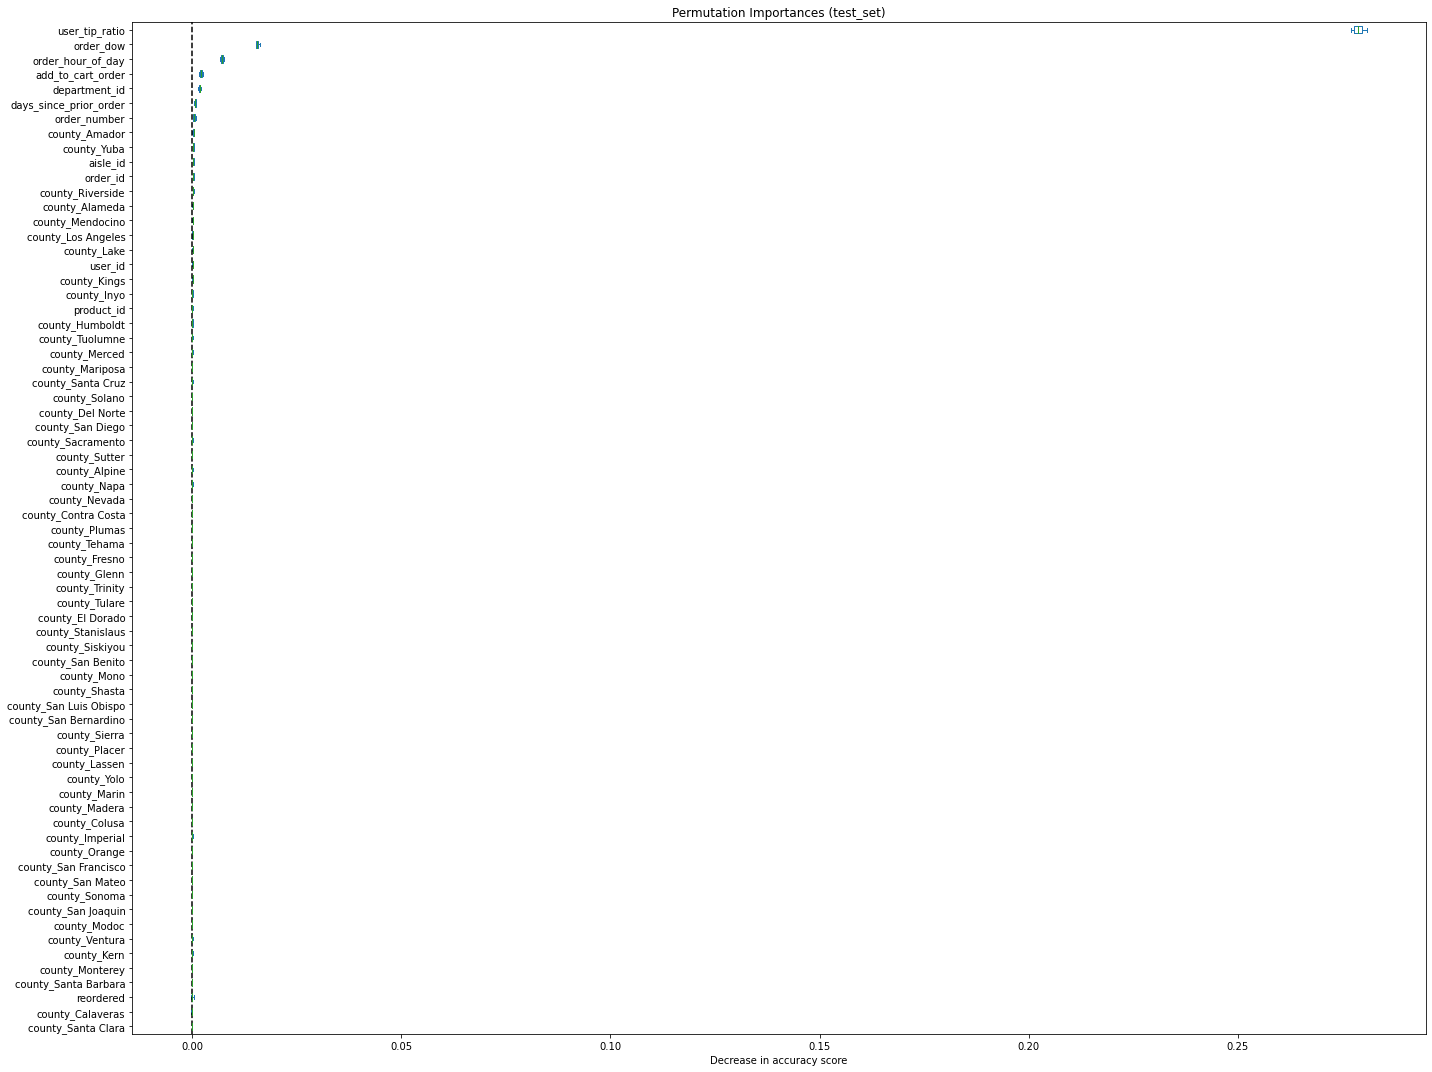

In [60]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_hgbc, X_test, y_test, n_repeats= 10, random_state= 0, n_jobs= -1)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
 result.importances[sorted_importances_idx].T,
 columns= X.columns[sorted_importances_idx]
)

ax= importances.plot.box(vert= False, whis= 10, figsize= (20, 15))
ax.set_title("Permutation Importances (test_set)")
ax.axvline(x= 0, color= "k", linestyle= "--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

#### **DTC**

In [34]:
gs_crss_dtc = GridSearchCV(
 estimator= DecisionTreeClassifier(),
 param_grid= dict(min_samples_split= [2, 10, 20, 50, 100], max_depth= [1, 3, 5, 9], random_state= [0]),
 scoring= "accuracy",
 n_jobs= -1
).fit(X_train, y_train)

print(f"Best param: {gs_crss_dtc.best_params_} with acc: {gs_crss_dtc.best_score_}")

Best param: {'max_depth': 9, 'min_samples_split': 2, 'random_state': 0} with acc: 0.7977387481454989


In [36]:
best_dtc = DecisionTreeClassifier(max_depth= 9, min_samples_split= 2, random_state= 0).fit(X_train, y_train)

y_best_train_pred = best_dtc.predict(X_train)
y_best_test_pred = best_dtc.predict(X_test)

print_evaluation("DTC", X_train, X_test, y_train, y_test, y_best_train_pred, y_best_test_pred)

DTC Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.80155 |        0.78594 |    0.77347 |   490613 |       69
Test      0.79806 |        0.78236 |    0.77199 |   122654 |       69



In [37]:
# 'user_tip_ratio': 0.9335026329367192

print(dict(zip(X.columns, best_dtc.feature_importances_)))

{'order_id': 0.0024360049000960726, 'product_id': 0.0002941600639374432, 'add_to_cart_order': 0.004543934555243233, 'reordered': 1.4006452455397546e-05, 'user_id': 0.0014912571131418101, 'order_number': 0.002158000094368512, 'order_dow': 0.031994586879281556, 'order_hour_of_day': 0.015698835635160557, 'days_since_prior_order': 0.0021133252192428995, 'aisle_id': 0.00029266787750085576, 'department_id': 0.00198819523612475, 'user_tip_ratio': 0.9335026329367192, 'county_Alameda': 2.5686705925057966e-05, 'county_Alpine': 0.0, 'county_Amador': 0.0002517415966053994, 'county_Calaveras': 0.0002145998600991861, 'county_Colusa': 0.00011324282612346281, 'county_Contra Costa': 6.191714564456485e-05, 'county_Del Norte': 1.5582200345398882e-05, 'county_El Dorado': 0.0, 'county_Fresno': 5.62191962117325e-05, 'county_Glenn': 0.00013983267567239921, 'county_Humboldt': 3.2728330163247195e-05, 'county_Imperial': 9.244352447895065e-05, 'county_Inyo': 9.02586806744768e-05, 'county_Kern': 0.000239670913510

#### **LRC**

In [43]:
pipe_lo = make_pipeline(StandardScaler(),
                     LogisticRegression(max_iter=500,dual=False)
                     )
param_grid_lo = {
"logisticregression__penalty": ["l1"],
"logisticregression__C": np.linspace(0.01, 10, 10),
"logisticregression__solver": ["saga"]
 
}
gs_crss_lrc = GridSearchCV(pipe_lo, param_grid_lo, scoring= "accuracy", n_jobs= -1).fit(X_train,y_train)

print(f"Best param: {gs_crss_lrc.best_params_} with acc: {gs_crss_lrc.best_score_}")

Best param: {'logisticregression__C': 3.34, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'} with acc: 0.7913875114628052


In [44]:
best_lrc = LogisticRegression(penalty= "l1", C= 3.34, solver= "saga").fit(X_train, y_train)

y_pred_train_best_lrc = best_lrc.predict(X_train)
y_pred_test_best_lrc = best_lrc.predict(X_test)

print_evaluation("LRC", X_train, X_test, y_train, y_test, y_pred_train_best_lrc, y_pred_test_best_lrc)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LRC Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.55328 |        0.00000 |    0.00000 |   490613 |       69
Test      0.54995 |        0.00002 |    0.50000 |   122654 |       69



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
print(dict(zip(X.columns, best_lrc.feature_importances_)))

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'